# Challenge: What is the future selling price of a home?

<br>
<br>

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important.

In this competition, students are required to develop a full-fledged approach to make predictions about the future sale prices of homes. A full-fledged approach constist, at least, in the following steps:

* Descriptive statistics about the data
* Data cleaning and pre-processing
* Defining a modeling approach to the problem
* Build such a statistical model
* Validate the outcome of the model

Now, should you ask a home buyer to describe their dream house, they probably wouldn't begin with describing features such as the height of the basement ceiling or the proximity to a railroad. As you will see, the dataset we use in this competition proves that many more features influence price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in a small city in the US, this competition challenges you to predict the final price of each home.

## Imports

We need to import Python libraries such as pandas, numpy or matplotlib, etc...

In [527]:
import os
import sys
import re
import random
import math
import scipy
import pylab as pl
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.patches as pat
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.cm as cm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold # import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

from mpl_toolkits.mplot3d import Axes3D
cmapRdYlGn = cm.get_cmap('RdYlGn')
cmap = cm.coolwarm




from datetime import datetime
from datetime import timedelta
from itertools import islice
#import statsmodels.api as sm

from IPython.display import HTML
#Map widget
#install = !pip install ipyleaflet
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON, DrawControl, LayerGroup, basemaps
)
#install = !pip install geocoder
#install = !apt-get install ImageMagick
import geocoder

# !apt-get install ImageMagick #Package to convert images to gif

## Retrieve the data

In order to analyse it, we need to retrieve the data which is in a csv file.

In [20]:
challenge_data_folder = "./challenge_data"

pdAllData_Categ = pd.read_csv(challenge_data_folder+"/train.csv",keep_default_na=False)
pdTestData_Categ = pd.read_csv(challenge_data_folder+"/test.csv",keep_default_na=False)
#Load training data keep_default_na FALSE to keep "Not available" data as they transport information

columnTypesDict = pdAllData_Categ.dtypes.to_dict() #Infer part of the data schema
columnNames = list(columnTypesDict.keys()) #List of all features name

In [21]:
pdAllData_Categ.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


We have now correctly imported the data that is now saved in a pandas dataframe structure.
<br>
We also have the list of the columns' names and their type.

At a first, the only information we have on the data set resides in the description file therefore we tried to match the data and the description file to make sure the data is clean and clear. One must first match features names and then specified values in the description file and in the dataset.

In [25]:
def checkWithDescription(description_file_Path):
    
    """Checks in the data for not mentioned values in the description file given."""
    
    #Importation of the text description
    pathDescr = (challenge_data_folder+description_file_Path)
    txtDescripData = open(pathDescr).readlines()
    
    columnIndex=[]
    nbHeader = 7
    NoHeaderTxtDescripData = txtDescripData[nbHeader:]
    #Parse the description file to retrieve all the lines that corresponds to features    
    for feature in columnNames:
        if feature == 'Id': continue
        for index,line in enumerate(NoHeaderTxtDescripData):
            if feature in line: #Match features name and stated name in the description
                if(line.split(feature)[0]=='' and line.split(feature)[1][0]==':' ): #Make sure exactly this feature in this line 
                    columnIndex.append((feature,index)) #We retrieved the line where the feature is described
                pass

    NoSpecificValfeatures = []
    SpecificVal = {} #Will contain as keys column names and values the specified values in the description file
    
    #Scan the cocument to retrieve specfic values for each featurz
    for index,featureLine in enumerate(columnIndex):

        startLine= featureLine[1]+2  #RTF file format 
        if index == len(columnIndex)-1: endLine = len(NoHeaderTxtDescripData)-1
        else: endLine = columnIndex[index+1][1]-1
        values = []
        if endLine <= startLine: #No specified value in the description file
            NoSpecificValfeatures.append(featureLine[0])
            continue
        for i in range(startLine,endLine):
            line = NoHeaderTxtDescripData[i] 
            values.append(line.split('\t')[0].strip())
        SpecificVal[featureLine[0]]=values #All values specified are retrieved and kept in this dictionary
        
    #Retrieve Bad values for the columns with specified values
    dicBadValues = []
    for factor in SpecificVal:

        #For a factor search for any value not specified in the description file 
        #In terms of type of valu

        typeCol = columnTypesDict[factor]
        if typeCol == 'int64': valSpec = [int(i) for i in SpecificVal[factor]]
        else: valSpec = SpecificVal[factor]
        pdInter = pdAllData_Categ.apply(lambda x: x[factor] not in valSpec,axis=1)
        potentialBadValues = pdAllData_Categ[pdAllData_Categ.apply(lambda x: x[factor] not in valSpec,axis=1)]
        nbBadVal = len(potentialBadValues)

        if nbBadVal>0:
            badValues = [factor]
            badValues.append(potentialBadValues.groupby(factor)[factor].count().to_dict())
            dicBadValues.append(badValues)
    #Retrieve Bad values for the columns with not specified values such as year of construction of 

    for feature in NoSpecificValfeatures:
        dtypeColumn = columnTypesDict[feature]
        if dtypeColumn=='float64': typeFun = float #infered type -> check if any values do not convert to this type
        elif dtypeColumn=='int64': typeFun = int
        else: typeFun=lambda x: True
        pdInter = pdAllData_Categ[pdAllData_Categ.apply(lambda x: (x[feature]=='NA') and typeFun(x[feature]) ,axis=1)]
        if len(pdInter)>0:
            badValues=[feature]
            badValues.append(pdInter.groupby(feature)[feature].count().to_dict())
            dicBadValues.append(badValues)
            
    return SpecificVal, NoSpecificValfeatures, dicBadValues

In [27]:
bad_description_file_Path = "/Bad_Description.rtf"
bad_specificVal, bad_noSpecificValfeatures, bad_dicBadValues = checkWithDescription(bad_description_file_Path)
bad_dicBadValues

[['MSZoning', {'C (all)': 9}],
 ['Neighborhood', {'NAmes': 179}],
 ['BldgType', {'2fmCon': 28, 'Duplex': 41, 'Twnhs': 37}],
 ['Exterior2nd', {'Brk Cmn': 7, 'CmentBd': 49, 'Wd Shng': 29}],
 ['MasVnrType', {'NA': 6}],
 ['LotFrontage', {'NA': 210}],
 ['MasVnrArea', {'NA': 6}],
 ['GarageYrBlt', {'NA': 67}]]

First of all, some column names were wrong in the description file erors. By deducing form the data, we changed Bedroom to BedroomAbvGr and Kitchen to KitchenAbvGr.
<br>
There are also errors in the values described.
<br>
In the result above, the number corresponds the how many times the key appears in the column. All the values that appear here are not consistent with the text description.
<br>
Most errors with the initial description are easily corrected by slighlty modifying the description file, but some are more complex and persist such as :<br>
<li>C(all): is it a commercial one or a sort of "we don't know", or another information?
<li>Twnhs: is it a townhouse end unit or a townhouse inside unit, or another townhouse not present in the text description? We don't know.
<br>
They have no direct typo or writings and the other values specified are included in the data.<br>
Although those values are not explicit in the description file, they contain information so we decided to keep them eventhough no direct explanation of those categories is available.

In [31]:
description_file_Path = "/Data description.rtf"
SpecificVal, NoSpecificValfeatures, dicBadValues = checkWithDescription(description_file_Path)
dicBadValues

[['MSZoning', {'C (all)': 9}],
 ['BldgType', {'Twnhs': 37}],
 ['MasVnrType', {'NA': 6}],
 ['LotFrontage', {'NA': 210}],
 ['MasVnrArea', {'NA': 6}],
 ['GarageYrBlt', {'NA': 67}]]

In [32]:
print('When GarageYrBlt = NA, GarageType has values',set(pdAllData_Categ[pdAllData_Categ.apply(lambda x: x.GarageYrBlt=='NA',axis=1)].GarageType.values))
print('When MasVnrArea = NA, MasVnrArea has values',set(pdAllData_Categ[pdAllData_Categ.apply(lambda x: x.MasVnrArea=='NA',axis=1)].MasVnrType.values))

When GarageYrBlt = NA, GarageType has values  {'NA'}
When MasVnrArea = NA, MasVnrArea has values {'NA'}


Now we have corrected some typos in the text description.
<br>
Otherwise, the other NA values can contain information or be explained by other specified values. The two cases above state that when a property has no garage, the year the garage has been built is not available and no MasVnrType implies no MasVnrArea which is reasonable but important to take into account.
<br>
To conclude on this, no purely invalid values have been spotted in the data.

## Data statistics

We need to understand the data we are working with.

### 1. Sale Price: the value to predict

To begin, we can try to understand the distribution of the saling price which is the value we'll try to guess according to the data we have.

Number of unvalid sample with a sale price <= 0: 0


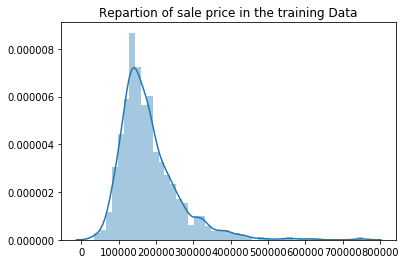

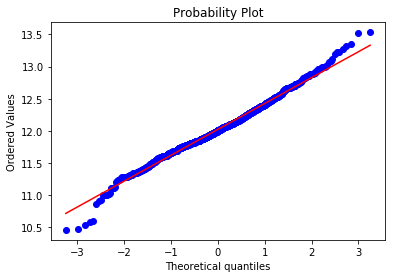

In [58]:
salePrices = pdAllData_Categ.SalePrice.tolist()

print("Number of unvalid sample with a sale price <= 0:",pdAllData_Categ.SalePrice[pdAllData_Categ.SalePrice<=0].count())

#plt.boxplot(salePrices, vert=False)
sns.distplot(salePrices)
plt.title("Repartion of sale price in the training Data")

plt.show()

probabilityPlot = scipy.stats.probplot(np.log(salePrices), plot=plt)

We note that the distribution seems to be lognormal. If it is, the log of the saling prices must be normal. In order to verify that, we can use a probability plot. The more the points are inline, the more it is close to a normal distribution, and the more the saling prices are a lognormal distribution.
<br>
We can see that the curve is really close to be a line (except for some points at the beginning and at the end), that means the saling price can be approched by a lognormal distribution.

### 2. Ground Living Area VS Sale Price: a good indicator?

When we buy a house, things that seem to be important for us to determine the price is the living area. We'll see how much this component is important to the price.

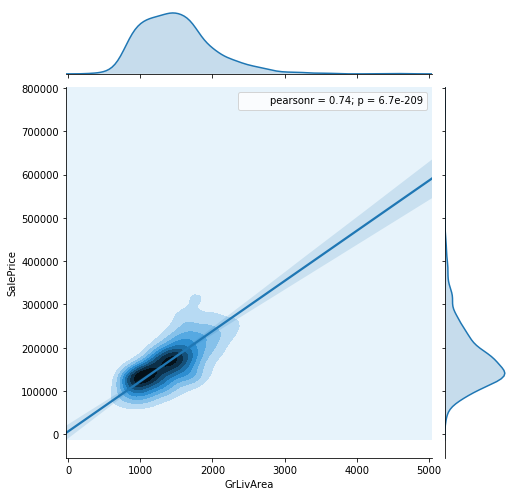

In [582]:
g = sns.jointplot("GrLivArea", "SalePrice", data=pdAllData_Categ, kind="kde", size=7)
sns.regplot("GrLivArea", "SalePrice", data=pdAllData_Categ, scatter=False, ax=g.ax_joint)
plt.show()

With this plot, we see the distribution of the Sale Price according to the Ground Living Area.
<br>
The two features seem to be correlated, the pearson correlation coefficient is 0.74. But the Ground Living Area seem to not be sufficient to guess the price because we see that the error can be large. Other factors have to be taken into account.

### 3. Neighborhood: the price depends on it?

When we want to buy a house, we know that the price for quite similar houses can be very different according to where it is. We'll study the influence of the neighborhood on the price.

In [126]:
dicStreetName = {} # Abbreviation : Street name
dicStreetLoc = {} # Abbreviation : location returned by geocoder
for index in range(92,117):
    line = txtDescripData[index]
    line = line.strip()
    line = line.split('\t')
    dicStreetName[line[0]]= line[1][:-1]
    dicStreetLoc[line[0]] = geocoder.google(line[1][:-1]+', Ames')

In [127]:
def calcAreasPrices(pdDF):
    """
    Returns dictionnaire = {"Neigborhood":areaPrice}
    
    """
    dicStreetPriceAreas={}
    
    def calcAreaPrice(row):
        neighborhood = row.Neighborhood
        try:
            dicStreetPriceAreas[neighborhood] #see if already defined
        except KeyError:
            dicStreetPriceAreas[neighborhood]=[0,0,0]
        dicStreetPriceAreas[neighborhood][0]+=row.SalePrice
        dicStreetPriceAreas[neighborhood][1]+=row.LotArea
        
    none = pdDF.apply(calcAreaPrice,axis=1) #fill the dictionnary
    
    for place in dicStreetPriceAreas:
        areaPrice = dicStreetPriceAreas[place][0]/dicStreetPriceAreas[place][1]
        dicStreetPriceAreas[place] = areaPrice
        
    return dicStreetPriceAreas
    
dicStreetPriceAreas = calcAreasPrices(pdAllData)
print(dicStreetPriceAreas)

{'CollgCr': 20.43893739265472, 'Veenker': 15.133918143832238, 'Crawfor': 16.92658934743337, 'NoRidge': 23.049928679388874, 'Mitchel': 14.23237526116939, 'Somerst': 29.55322320949371, 'NWAmes': 16.49992834611817, 'OldTown': 15.708946967813892, 'BrkSide': 16.910100475938656, 'Sawyer': 13.4242253219904, 'NridgHt': 28.8899788413152, 'NAmes': 14.189682044633944, 'SawyerW': 19.38387882154937, 'IDOTRR': 12.054208428802571, 'MeadowV': 41.25743415463042, 'Edwards': 12.843999136512851, 'Timber': 9.50119128123673, 'Gilbert': 17.19430711971769, 'StoneBr': 29.490541930638102, 'ClearCr': 6.732846177897465, 'NPkVill': 49.569387355646896, 'Blmngtn': 57.70382718760606, 'BrDale': 59.280813815945116, 'SWISU': 17.504403242359622, 'Blueste': 84.61538461538461}


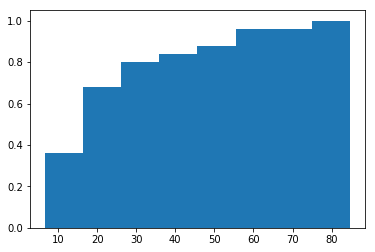

In [179]:
areaPrices = calcAreasPrices(pdAllData).values()
hist = plt.hist(areaPrices, cumulative=True, normed=True, bins='auto')
plt.title('')
plt.show()

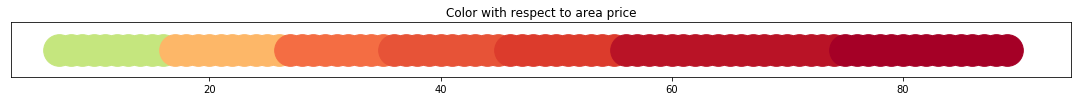

Area Price around Ames


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[42.0307812, -93.63191309999999], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), LayerGroup(layers=(CircleMarker(color='#fdb768', fill_color='#fdb768', location=[None, None], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#c5e67e', fill_color='#c5e67e', location=[None, None], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#fdb768', fill_color='#fdb768', location=[42.0262539, -93.6204523], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#fdb768', fill_color='#fdb768', location=[None, None], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#c5e67e', fill_color='#c5e67e', location=[None, None], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#f46d43', fill_color='#f46d43', location=[None, None], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#fdb768', fill_color='#fdb768', location=[None, None], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#c5e67e', fill_color='#c5e67e', location=[None, None], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#fdb768', fill_color='#fdb768', location=[None, None], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#c5e67e', fill_color='#c5e67e', location=[None, None], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#f46d43', fill_color='#f46d43', location=[None, None], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#c5e67e', fill_color='#c5e67e', location=[None, None], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#fdb768', fill_color='#fdb768', location=[42.0339027, -93.6770658], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#c5e67e', fill_color='#c5e67e', location=[None, None], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', '

In [176]:
markersList = []
for place in dicStreetPriceAreas:
    coordGeo = dicStreetLoc[place]
    areaPrice = dicStreetPriceAreas[place]
    try:
        lastLowerValuesIndex = list(map(lambda x: x <= areaPrice,hist[1])).index(False)-1
    except ValueError:
        lastLowerValuesIndex = len(hist[0])-1
    #print(lastLowerValuesIndex)
    colorfloat = hist[0][lastLowerValuesIndex] #Use the cumulative hist to get the color
    #colorfloat = (-minAreaPrice)/(maxAreaPrice-minAreaPrice)

    #print(dicStreetPirceArea[place][2],colorfloat)
    markerColor = colors.rgb2hex(cmapRdYlGn(1-colorfloat))#green to red
    marker = CircleMarker(location=(coordGeo.lat, coordGeo.lng), radius=10, color=markerColor, fill_color=markerColor)
    markersList.append(marker)

g = geocoder.google('Ames')
m = Map(center=[g.lat, g.lng], zoom=11)

markersList = [x for x in markersList if x!=None]
group = LayerGroup(layers=markersList)

#PLot color bar
fig,ax = fig, ax = plt.subplots(figsize=(19,1))
plt.title("Color with respect to area price")
minPriceArea,maxPriceArea = 7,90
for areaPrice in np.arange(minPriceArea,maxPriceArea,1):
    try:
        lastLowerValuesIndex = list(map(lambda x: x<= areaPrice,hist[1])).index(False)-1
    except ValueError:
        lastLowerValuesIndex = len(hist[0])-1
    #print(lastLowerValuesIndex)
    colorfloat = hist[0][lastLowerValuesIndex] #Use the cumulative hist to get the color
    plt.scatter(areaPrice,0,c = cmapRdYlGn(1-colorfloat),s=1000)
plt.setp( ax.get_yticklabels(), visible=False)
ax.yaxis.set_ticks_position('none') 
plt.show()

m.add_layer(group)
print("Area Price around Ames")
m

COMMENT ON THE MAP.

### 4. MSZoning: general zoning of the sale

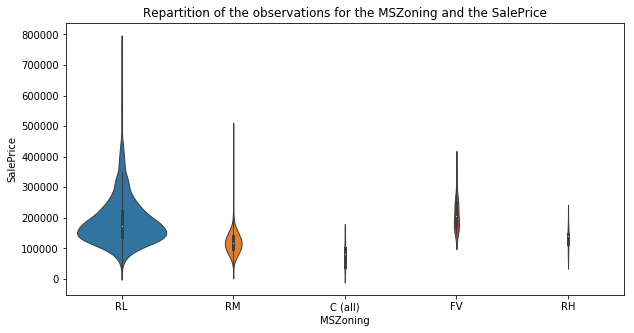

In [208]:
#sns.lmplot("MSSubClass", "SalePrice", data=pdAllData_Categ)
plt.figure(figsize=(10,5))
sns.violinplot("MSZoning", "SalePrice", data=pdAllData_Categ, linewidth=1, scale='count')
plt.title('Repartition of the observations for the MSZoning and the SalePrice')
plt.show()

Here we don't have all the expected categories. We note that the C category is missing, where we have a 'C (all)'. It can maybe replace the C category but we don't know. In the next steps, we'll process the categorized features to have numbers instead, so it's not really important to have a C (all) instead of a C.
<br>
We also see that the RL category has the larger count of observations.

### 5. Conditions: A first and a second condition

We have 2 features for the proximity to conditions and the list of possible conditions is the same.
<br>
We'll first verify that we don't have the same condition twice. Another thing to verify is that when the second condition is not Norm, the first mustn't be Norm.

In [270]:
print(pdAllData_Categ.groupby(['Condition1', 'Condition2']).size())

Condition1  Condition2
Artery      Artery           2
            Norm            38
            PosA             1
Feedr       Feedr            1
            Norm            61
            RRAn             1
            RRNn             2
Norm        Norm          1035
PosA        Norm             7
PosN        Norm            15
            PosN             2
RRAe        Norm             8
RRAn        Feedr            4
            Norm            17
RRNe        Norm             2
RRNn        Feedr            1
            Norm             3
dtype: int64


The dataset seems to indicate that when there is only 1 condition, the 2nde one is set to 'Norm' that means Normal condition.
<br>
The only cases where we have twice the same are for the first condition "Artery", "Feedr" and "PosN".
<br>
But maybe the house is near several arteries, several secondary roads, or several parks...
<br>
As we can't say if it's an error, we decided not to modify it.
<br><br>
'Norm' seems to be the value by default when you have nothing else. The condition1 seems to be the first columns where you can find the most important condition, because it's filled first. If the first one is 'Norm', the second one is 'Norm' too. And if the second one isn't 'Norm', it means that the first one wasn't 'Norm'.

### 6. Overall Quality and Condition

In [331]:
series = pdAllData_Categ.groupby(['OverallQual', 'OverallCond'])['SalePrice'].mean()
nb = pdAllData_Categ.groupby(['OverallQual', 'OverallCond']).size()
ovQual, ovCond = series.keys().labels[0], series.keys().labels[1]
meanSalePrice = series.values

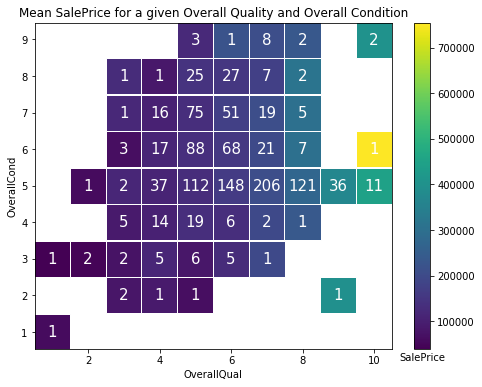

In [376]:
plt.figure(figsize=(8,6))
plt.scatter(ovQual+1, ovCond+1, c=meanSalePrice, s=1300, marker='s', edgecolor='w')
plt.xlabel('OverallQual'),plt.ylabel('OverallCond')
plt.title('Mean SalePrice for a given Overall Quality and Overall Condition')
cbar = plt.colorbar()
cbar.ax.set_xlabel('SalePrice')

for i in range(len(ovQual)):
    plt.text(ovQual[i]+1, ovCond[i]+1, str(nb.values[i]), color="w", fontsize=15, horizontalalignment='center', verticalalignment='center')

plt.show()

The overall quality seems to have a lot more influence than the overall condition. The only one yellow price is not representative because there is only 1 observation to calculate this mean price. It could be considered as an outlier for the feature OverallCond according to the SalePrice... We have to remember its ID, just in case.

In [377]:
pdAllData_Categ.loc[(pdAllData_Categ['OverallQual']==10) & (pdAllData_Categ['OverallCond']==6)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104,21535,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,1,2007,WD,Normal,755000


### 7. Building Type: check the Townhouses

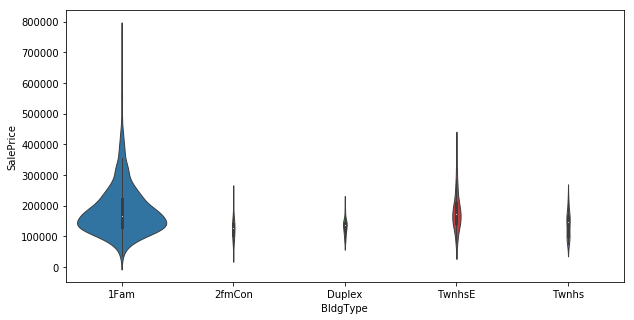

In [381]:
plt.figure(figsize=(10,5))
sns.violinplot("BldgType", "SalePrice", data=pdAllData_Categ, linewidth=1, scale='count')
plt.show()

We had a doubt at the beginning for the Twnhs that hadn't a letter, such as E for End or I for Inside. We note that we don't have any TwnhsI, maybe the Twnhs without letter are the TwnhsI, maybe we don't know. We decide to keep the information like it.
<br>
The 1Fam category has a lot of observations.

### 8. How old is the house?

The age of a house always has an influence on the price, and also the date when it was built, and when it was sold. Do we need to consider a new feature that is the age, or do we already have the good features in the dataset?

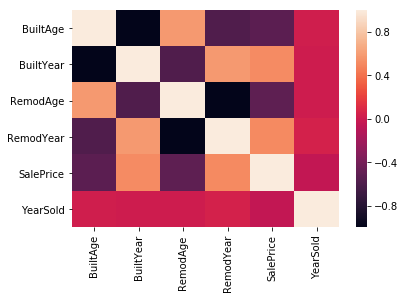

Correlation of features with SalePrice:
 BuiltAge    -0.524754
BuiltYear    0.523194
RemodAge    -0.513059
RemodYear    0.509916
YearSold    -0.039841
Name: SalePrice, dtype: float64


In [651]:
ageData = {
    'BuiltYear': pdAllData_Categ.YearBuilt,
    'RemodYear': pdAllData_Categ.YearRemodAdd,
    'YearSold': pdAllData_Categ.YrSold,
    'BuiltAge': yearSold - yearB,
    'RemodAge': yearSold - yearR,
    'SalePrice': pdAllData_Categ.SalePrice,
}

matCorrAge = pd.DataFrame(ageData).corr()

sns.heatmap(matCorrAge)
plt.show()

print('Correlation of features with SalePrice:\n',matCorrAge.loc['SalePrice'].drop('SalePrice'))

The year when the house is sold has a really low correlation with the SalePrice.
<br>
The year when it was built or remoded has more correlation. We wondered if changing from a year to an age was a good idea or not.
<br>
In the case of the BuiltYear, the gain of correlation is about 0.001. In the case of the Remod Year, the gain of correlation is about 0.003.
<br>
That means we could replace the builtYear by the builtAge, and the RemodYear by the RemodAge to get better results, but we decided that the gain in the correlation was not sufficient to change this.

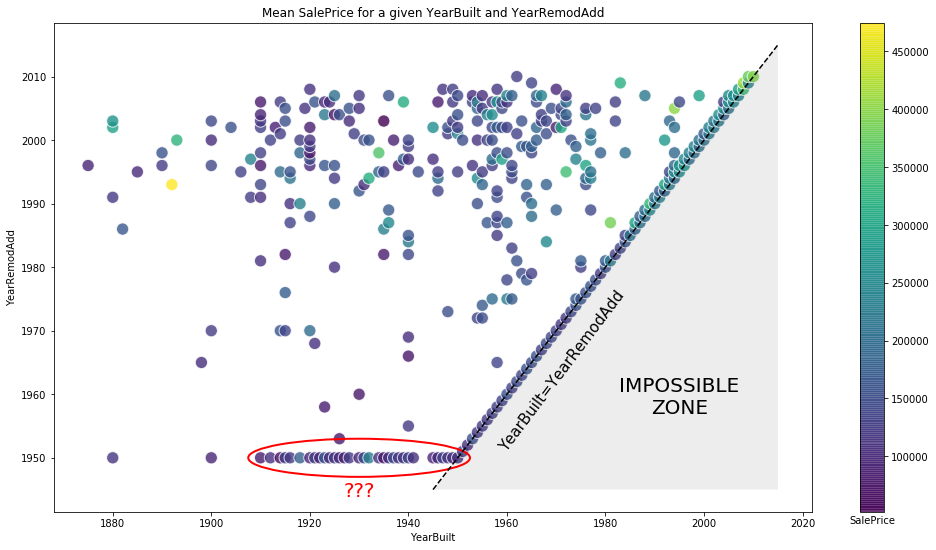

In [557]:
#Retrieve the data

series = pdAllData_Categ.groupby(['YearBuilt', 'YearRemodAdd'])['SalePrice'].mean()
nb = pdAllData_Categ.groupby(['YearBuilt', 'YearRemodAdd']).size()
labels0, labels1 = series.keys().labels[0], series.keys().labels[1]
levels0, levels1 = series.keys().levels[0], series.keys().levels[1]
yB, yR = [levels0[label] for label in label0], [levels1[label] for label in label1]
meanSalePrice = series.values

#Plot

plt.figure(figsize=(17,9))

plt.scatter(yB, yR, c=meanSalePrice, s=150, edgecolor='w', alpha=0.8)
plt.xlabel('YearBuilt'),plt.ylabel('YearRemodAdd')
plt.title('Mean SalePrice for a given YearBuilt and YearRemodAdd')
cbar = plt.colorbar()
cbar.ax.set_xlabel('SalePrice')

plt.plot([1945,2015],[1945,2015],'k--')
plt.fill([1945,2015,2015],[1945,2015,1945], 'k', alpha=0.07)
plt.text(1958,1975,'YearBuilt=YearRemodAdd', rotation=53, fontsize=15)
plt.text(1995,1957,'IMPOSSIBLE\nZONE', fontsize=20, horizontalalignment='center')

ax = plt.gca()
ax.add_artist(pat.Ellipse((1930,1950),45,6,color='r',fill=False,lw=2,ls='solid'))
plt.text(1930,1944,'???',horizontalalignment='center',color='r',fontsize=20)

plt.show()

Another thing that could be analysed is the fact that the RemodYear is always after the BuiltYear. Indeed, we can see on the graph that there aren't any observations in the "impossible zone".
<br>
A lot of observations are on the YearBuilt=YearRemodAdd line, that means they haven't been remoded yet (when the house has been sold).
<br>
We have a corridor of approximately '10 years' where very few observations, that means recently built houses are not often remoded.
<br>
The SalePrice is higher for more recent houses. Houses that haven't been remoded within the last 20 years seem to have a lower SalePrice. The house with the higher SalePrice is old, but has been remoded after 1990.
<br><br>
Another thing that can be noted is that a lot of observations seem to have been remoded in 1950 (that also seems to be a limit year because no houses are known to be remoded before this date). The question is: is it the real year of remoding, or maybe when Ames begun to collect the data, they didn't know the information and decided to put 1950...
<br>
The idea to clean this problem in the data could be to align these observations on the YearBuilt=YearRemodAdd line, but actually we don't know... So we decided to do nothing with it.

## Data cleaning: label encoder

In order to replace the categorised data by numbers, we can use the automatic label encoder, or we can try to replace the values according to the related median SalePrice.

In [ ]:
df.replace({'A': {0: 100, 4: 400}}) #replace dans la colonne A, le 0 par 100 et le 4 par 400
df.apply(lambda column: labelEncoderOrdered(column), axis=0) #axis0 sur chaque colonne

In [687]:
df1 = pdAllData_Categ.groupby('MSZoning')['SalePrice'].median().reset_index(name='median').sort_values('median')
print(df1)
print(df1.values)
dictio = {}
for i,valueList in enumerate(df1.values):
    dictio[valueList[0]] = i
print(dictio)

  MSZoning  median
0  C (all)   81000
4       RM  118000
2       RH  142000
3       RL  174000
1       FV  205950
[['C (all)' 81000]
 ['RM' 118000]
 ['RH' 142000]
 ['RL' 174000]
 ['FV' 205950]]
{'C (all)': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4}


In [715]:
def labelEncodingOrdered(column):
    #print('columnName',column.name)
    colANDprice = pd.DataFrame({str(column.name): column, 'SalePrice': salePrice})
    #print(colANDprice)
    valueDF = colANDprice.groupby(str(column.name))['SalePrice'].median().reset_index(name='median').sort_values('median').values
    #print('valueDF\n',valueDF)
    dictio = {}
    for i,valueList in enumerate(valueDF):
        dictio[valueList[0]] = i
    return column.replace(dictio)

In [716]:
salePrice = pdAllData_Categ.SalePrice
pdAllData = pdAllData_Categ.apply(lambda column: labelEncodingOrdered(column), axis=0)

In [717]:
pdAllData

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,879,14,3,41,526,1,1,0,1,1,...,0,0,4,3,16,8,1,5,4,374
1,745,10,3,31,297,1,1,0,1,1,...,0,0,4,3,16,2,4,5,4,308
2,935,14,3,49,680,1,1,1,1,1,...,0,0,4,3,16,10,1,5,4,402
3,411,9,3,7,274,1,1,1,1,1,...,0,0,4,3,16,8,2,5,1,177
4,1019,14,3,83,753,1,1,1,1,1,...,0,0,4,3,16,9,1,5,4,450
5,436,4,3,46,553,1,1,1,1,1,...,0,0,1,1,11,4,3,5,4,185
6,1107,10,3,34,771,1,1,0,1,1,...,0,0,4,3,16,6,4,5,4,515
7,841,14,3,36,454,1,1,1,1,1,...,0,0,4,1,17,11,3,5,4,353
8,300,4,1,6,204,1,1,0,1,1,...,0,0,4,3,16,1,1,5,1,137
9,201,3,3,5,167,1,1,0,1,1,...,0,0,4,3,16,0,1,5,4,101


## The random lognormal model: a naive model